In [41]:
import numpy as np
% matplotlib inline 
import matplotlib.pyplot as plt


In [1]:
from pcc import get_radar_locations

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import wradlib
import glob
from scipy import stats, linspace
import scipy as sp
import wradlib as wrl
from osgeo import osr
from pcc import get_time_of_gpm
from pcc import cut_the_swath

## Landgrenzenfunktion
## -------------------
from pcc import boxpol_pos
bonn_pos = boxpol_pos()
bx, by = bonn_pos['gkx_ppi'], bonn_pos['gky_ppi']
bonnlat, bonnlon = bonn_pos['lat_ppi'], bonn_pos['lon_ppi']
from pcc import plot_borders
from pcc import plot_radar
from pcc import get_my_cmap
my_cmap = get_my_cmap()

from pcc import get_my_cmap
my_cmap2 = get_my_cmap()


In [3]:
def ipoli_radi_fast(gr_grid, gr_data,sr_grid,radius):
    """

    Parameters
    ----------
    gr_grid ::: grid of the Ground Radar
    gr_data ::: data of the Ground Radar
    sr_grid ::: grid oft the Spaceborn Radar
    radius  ::: radius of the dpr foot prints


    Returns
    -------
    gs_grid ::: Interpolated Groundradar Data on Spaceborne Grid

    """

    gr_ipoli_data = np.zeros((sr_grid.shape[0]))

    for i in range(sr_grid.shape[0]):

        x0, y0 = sr_grid[i,0], sr_grid[i,1]  ###########x y richtig?

        rr = np.sqrt((gr_grid[:,0] - x0)**2 + (gr_grid[:,1] - y0)**2)
        ## Todo: hier fehlt die Wichtung
        #print (gr_data[rr < radius])
        gr_ipoli_data[i] = np.nanmean(gr_data[rr < radius])
        #if gr_data[rr < radius].size!=0:

            #gr_ipoli_data[i] = np.nanmax(gr_data[rr < radius])
        #else:
            #gr_ipoli_data[i] = np.nan
            # mein Pull Verfahren
            # pull_range = 1 #km
            # gr_ipoli_data[i] = np.nanmax(gr_data[rr < radius + pull_range])

    return gr_ipoli_data

In [ ]:
%%time
from pcc import plot_radar2

In [ ]:
def plot_all_cband(ax):
    for i in get_radar_locations().keys():


        plot_radar2(get_radar_locations()[i]['lon'],
                    get_radar_locations()[i]['lat'], ax , reproject=True, cband=True, col='black')

In [260]:
def sr_in_gr_area(bingrid, gpm_x, gpm_y, gpm_data, inner_poly_cut=True):
    """
    Funktion:
    ---------
    Search for SR Footprint (Index) that are located in the GR scan area 
    
    Input: 
    ------
    bingrid ::: Binary-grid of the GR scan area
        
    
    Output:
    -------
    
    """
    # Bestimmen von Eckpunkten bei RADOLAN RY GRID!
    # HARDCODED: but ok for regula RADOLAN Produkts
    xmin, xmax = -523.4621669218559, 375.5378330781441
    ymin, ymax = -4658.644724265572, -3759.644724265572
    
    # Radolangitter um 1 gridpoit zu allen seiten erweitern
    xex, yex = np.arange(xmin-1, xmax+2, 1), np.arange(ymin-1, ymax+2, 1)
    xxx, yyy = np.meshgrid(xex,yex)
    
    # Bin grid bestimmen
    bingrid[bingrid>=0]=1
    bingrid[bingrid<0]=0
    
    # Gittererweiterungen zusammenstellen
    ## rn_tb ::: bin gird top and bottom
    ## rn_lr ::: bin gird left and right
    rn_tb = np.zeros(900)
    rn_lr = np.zeros(902)
    
    # Griderweiterungen einsetzen
    # erst oben und unten
    rn1 = np.c_[rn_tb, bingrid, rn_tb]
    # dann rechts
    rn2 = np.vstack((rn1, rn_lr))
    # dann rechts
    rn3 = np.vstack((rn_lr,rn2))
    
    from skimage import measure
    # Contouren des Bin-grids erstellen
    contours = measure.find_contours(rn3, 0, positive_orientation='high',
                                     fully_connected='high' )

    # bestiimung der Listen für Polygon Points
    xx = []
    yy = []

    # suche nach dem größten Polygon... dieser sollte der RADOLAN UMRISS sein
    for i in range(len(contours)):
        # Polygone mit 3 oder weniger points ergeben keine nutzbare Fläche
        if len(xxx[contours[i][:,0].astype(int),contours[i][:,1].astype(int)]) <= 3:
            print('not relevant polygon')
        else:   
            # PolygonPoints bestimmen (RADOLAN RAND POINTS)
            xx.append(xxx[contours[i][:,0].astype(int),contours[i][:,1].astype(int)])
            yy.append(yyy[contours[i][:,0].astype(int),contours[i][:,1].astype(int)])
            
    # sortiern nach der länge, das letzt element ist das größte und sollte somit der Radolarand sein
    xx.sort(key=len)
    yy.sort(key=len)

    # Outter polygon erstellen
    xy = np.vstack((xx[-1].ravel(), yy[-1].ravel())).transpose()    
    
    # GPM Koordinaten revelen 
    gpm_xy = np.vstack((gpm_x.ravel(), gpm_y.ravel())).transpose()
    
    # Suche nach den GPM footprints im Scanngebiet von RADOLAN mit ZONALSTATS
    zdpoly = wradlib.zonalstats.ZonalDataPoly(gpm_xy, [xy])
    idx = zdpoly.get_source_index(0)
    
    # Anwenden von Indizes an 
    gpm_data_new = gpm_data.ravel()[idx]
    gpm_xy_new = gpm_xy[idx,:] 
    
    if inner_poly_cut==True:
        # Entferne Inner Polygons
        # Auch nur wenn es weitere Polygone gibt 
        if len(xx)>1:

            for inner_poly_index in range(len(xx)-1):

                print ('Polygon size: ', len(xx[inner_poly_index].ravel()))

                xy_inner = np.vstack((xx[inner_poly_index].ravel(),
                                      yy[inner_poly_index].ravel())).transpose()

                zdpoly = wradlib.zonalstats.ZonalDataPoly(gpm_xy_new, [xy_inner])

                idx = zdpoly.get_source_index(0)
                if idx.size==0:
                    print ('inner polygon do not match with SR grid')

                else:
                    print('match points with inner polygon', gpm_data_new[idx].shape)
                    gpm_data_new[idx] = np.nan
                    
                    
    return gpm_xy_new, gpm_data_new 
        

In [269]:
#%%time

#20150128

zz = np.array(['20141007'])


for i in range(len(zz)):
    ZP = str(zz[i])
    #year, m, d, ht, mt, st = ZP[0:4], ZP[4:6], ZP[6:8], ZP[8:10], ZP[10:12], ZP[12:14]
    year, m, d = ZP[0:4], ZP[4:6], ZP[6:8]

    ye = ZP[2:4]

    ## Read GPM Data
    ## -------------
    pfad_gpm_g = glob.glob("/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308."
                           +str(year)+str(m)+str(d)+"*.HDF5")[0]
    gpmdpr = h5py.File(pfad_gpm_g, 'r')
    gprof_lat = np.array(gpmdpr['NS']['Latitude'])
    gprof_lon = np.array(gpmdpr['NS']['Longitude'])
    gprof_pp = np.array(gpmdpr['NS']['SLV']['precipRateESurface'])
    gprof_pp[gprof_pp ==-9999.9]= np.nan

    gpm_time = gpmdpr['NS']['ScanTime']
    gpm_zeit = get_time_of_gpm(gprof_lon, gprof_lat, gpm_time)

    ht, mt = gpm_zeit[14:16], str(int(round(float(gpm_zeit[17:19])/5.0)*5.0))
    if mt == '0':
        mt = '00'
    elif mt == '5':
        mt = '05'
    print mt
    print gpm_zeit
    
    ## GPM Koordinaten im RADOLAN Bereich
    ## ----------------------------------------------
    gprof_lon, gprof_lat, gprof_pp_b = cut_the_swath(gprof_lon,gprof_lat,gprof_pp, eu=0)
    
    ## GPM Koordinaten in dwd_radolan_kartesisch
    ## ----------------------------------------------
    
    proj_stereo = wrl.georef.create_osr("dwd-radolan")
    proj_wgs = osr.SpatialReference()
    proj_wgs.ImportFromEPSG(4326)

    gpm_x, gpm_y = wradlib.georef.reproject(gprof_lon, gprof_lat,
                                            projection_target=proj_stereo,
                                            projection_source=proj_wgs)
    
    ## Read RADOLAN Data
    ## -----------------
    r_pro = 'ry'

    pfad = ('/automount/radar/dwd/'+ r_pro +'/'+str(year)+'/'+str(year)+'-'+
            str(m)+'/'+ str(year)+'-'+str(m)+'-'+str(d)+'/raa01-'+r_pro+'_10000-'+
            str(ye)+str(m)+ str(d)+str(ht)+str(mt)+'-dwd---bi*')


    rwdata, rwattrs = wradlib.io.read_RADOLAN_composite(glob.glob(pfad)[0])

    radolan_zeit = rwattrs['datetime'].strftime("%Y.%m.%d -- %H:%M:%S")


    radolan_grid_xy = wradlib.georef.get_radolan_grid(900,900)
    x = radolan_grid_xy[:,:,0]
    y = radolan_grid_xy[:,:,1]
    rwdata = np.ma.masked_equal(rwdata, -9999) *8#/ 2 - 32.5
    
    bingrid = rwdata.copy()
    
    ## Remove all SR Measurements that are not in the area of GR
    gpm_xy_new, gpm_data_new = sr_in_gr_area(bingrid, gpm_x, gpm_y, gprof_pp_b )
    
    # Nur RY daten mit Niederschlag betrechten
    # Wichtig. Erst nach der sr_in_gr_are berechnung benutzen
    rwd = rwdata.copy()
    th_rr = 0.5
    rwdata = rwdata[rwd > th_rr]
    x = x[rwd > th_rr]
    y = y[rwd > th_rr]
    
    ## INTERLOLATION
    ## --------------
    gk3 = wradlib.georef.epsg_to_osr(31467)

    #grid_gpm_xy = np.vstack((gpm_x.ravel(), gpm_y.ravel())).transpose()
    # grid_gpm_xy ist jetzt schon berechnet mit gpm_xy_new
    xy = np.vstack((x.ravel(), y.ravel())).transpose()

    # dpr footprint 5.2, radius 2.6
    dpr_footprint = 2.6
    
    result = ipoli_radi_fast(xy, rwdata.ravel().filled(np.nan),gpm_xy_new, dpr_footprint - 0.5)
    
    rrr = np.ma.masked_invalid(result)

    #rrr = result.reshape(gpm_x.shape)

    gpm_data_new[gpm_data_new<=0.5]=np.nan
    
    ggg = gpm_data_new
    
    


35
2014.10.07 -- 02:35:27


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: Mean of empty slice


In [270]:
print (ggg.shape, rrr.shape, gpm_xy_new.shape)
print (np.unique(rrr),np.nanmin(ggg))

((7884,), (7884,), (7884, 2))
(masked_array(data=[0.56, 0.5700000000000001, 0.5760000000000001, ...,
                   11.76, 47.04, --],
             mask=[False, False, False, ..., False, False,  True],
       fill_value=1e+20), 0.5006684)


In [271]:
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.scatter(gpm_xy_new[:,0],gpm_xy_new[:,1],
            c=np.ma.masked_invalid(ggg),
            cmap=my_cmap2, vmin=0.5, vmax=10, edgecolors='none')
plt.colorbar()
plt.title('GPM DPR')
plt.xlim(-400,400)
plt.ylim(-4700,-3900)

plt.subplot(2,1,2)
plt.scatter(gpm_xy_new[:,0],gpm_xy_new[:,1],
            c=np.ma.masked_invalid(rrr),
            cmap=my_cmap2, vmin=0.5, vmax=10, edgecolors='none')
plt.colorbar()
plt.title('RY')
plt.xlim(-400,400)
plt.ylim(-4700,-3900)

plt.show()

In [178]:
# Bestimmen von Eckpunkten bei RADOLAN GRID!
print (x.min(), x.max())
print (y.min(), y.max())

xmin, xmax = -523.4621669218559, 375.5378330781441
ymin, ymax = -4658.644724265572, -3759.644724265572

# Radolangitter um 1 gridpoit zu allen seiten erweitern
xex, yex = np.arange(x.min()-1, x.max()+2,1), np.arange(y.min()-1, y.max()+2,1)
xxx, yyy = np.meshgrid(xex,yex)

(-523.4621669218559, 375.5378330781441)
(-4658.644724265572, -3759.644724265572)


In [179]:
print xxx.shape
print (xxx.min(), xxx.max())
print (yyy.min(), yyy.max())

(902, 902)
(-524.4621669218559, 376.5378330781441)
(-4659.644724265572, -3758.644724265572)


In [180]:
# Bin grid bestimmen
rn = rwdata.copy()
rn[rn>=0]=1
rn[rn<0]=0

radolan_x, radolan_y = x[rwdata>=0],y[rwdata>=0]
gpm_x, gpm_y = gpm_x.ravel(),gpm_y.ravel()

In [181]:
rn.shape

(900, 900)

In [182]:
# Gittererweiterungen zusammenstellen
## rn_tb ::: bin gird top and bottom
## rn_lr ::: bin gird left and right
rn_tb = np.zeros(900)
rn_lr = np.zeros(902)
#print(rn_tb.shape, rn_lr.shape)

((900,), (902,))


In [183]:
# Griderweiterungen einsetzen
# erst oben und unten
rn1 = np.c_[rn_tb, rn, rn_tb]
# dann rechts
rn2 = np.vstack((rn1, rn_lr))
# dann rechts
rn3 = np.vstack((rn_lr,rn2))

In [184]:
rn3.shape

(902, 902)

In [185]:
from skimage import measure
# Contouren des Bin-grids erstellen
contours = measure.find_contours(rn3, 0, positive_orientation='high', fully_connected='high' )

In [186]:
fig, ax = plt.subplots()
#ax.imshow(rn, interpolation='nearest', cmap=plt.cm.jet)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [187]:
# das größte array ist der RADOLAN Umfang
len(max(contours,key=len))

3174

In [188]:
## Erstelle Rand
## --------------

# Anzahl der Kontour linien
clen = len(contours)

# bestiimung der Listen für Polygon Points
xx = []
yy = []

# suche nach dem größten Polygon... dieser sollte der RADOLAN UMRISS sein
for i in range(len(contours)):
    # Polygone mit 3 oder weniger points ergeben keine nutzbare Fläche
    if len(xxx[contours[i][:,0].astype(int),contours[i][:,1].astype(int)]) <= 3:
        print('not relevant polygon')
    else:   
        # PolygonPoints bestimmen (RADOLAN RAND POINTS)
        xx.append(xxx[contours[i][:,0].astype(int),contours[i][:,1].astype(int)])
        yy.append(yyy[contours[i][:,0].astype(int),contours[i][:,1].astype(int)])


In [189]:
for j in range(len(xx[:])):
    plt.plot(xx[j],yy[j], lw=3)
    print(len(xx[j]))
plt.show()

3174
5
70


In [190]:
from shapely.geometry.multipolygon import MultiPolygon
from shapely import wkt
from shapely import geometry


3


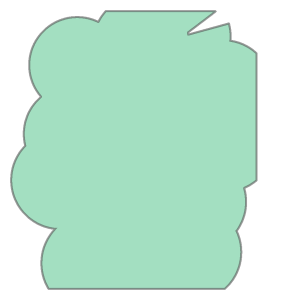

In [191]:
#bestimme die Position des größten Polygons
print len(xx)
# sortiern nach der länge, das letzt element ist das größte und sollte somit der Radolarand sein
xx.sort(key=len)
yy.sort(key=len)

# Outter polygon erstellen
xy = np.vstack((xx[-1].ravel(), yy[-1].ravel())).transpose()

poly_radolan = geometry.Polygon(xy)
poly_radolan

In [192]:
# GPM Koordinaten revelen 
gpm_xy = np.vstack((gpm_x.ravel(), gpm_y.ravel())).transpose()


In [193]:
print gpm_xy.shape
print xy.shape

(11074, 2)
(3174, 2)


In [194]:
print gpm_xy.shape
print xy.shape

(11074, 2)
(3174, 2)


In [195]:
%%time

# Suche nach den GPM footprints im Scanngebiet von RADOLAN
zdpoly = wradlib.zonalstats.ZonalDataPoly(gpm_xy, [xy])
idx = zdpoly.get_source_index(0)



CPU times: user 486 ms, sys: 31.4 ms, total: 517 ms
Wall time: 490 ms


In [196]:
gpm_data_new = gprof_pp_b.ravel()[idx]
gpm_xy_new = gpm_xy[idx,:] 
print gpm_xy_new.shape


(5793, 2)


In [197]:
zdpoly.dump_vector('testi')

In [198]:
gprof_pp_b.ravel().shape


(11074,)

In [205]:
plt.scatter(gpm_xy_new[:,0],gpm_xy_new[:,1], c=np.ma.masked_invalid(gpm_data_new), edgecolors='none', vmax=10, vmin=0.5)
plt.colorbar()
plt.plot(xy[:,0],xy[:,1])

plt.show()

In [212]:
# Entferne Inner Polygons
## len(xx)-1 um den outter nicht mit zu benutzen

# Nur wenn es weitere Polygone gibt 
if len(xx)>1:

    for inner_poly_index in range(len(xx)-1):

        print ('Laufindex: ',inner_poly_index)
        print ('Polygon size: ', len(xx[inner_poly_index].ravel()))

        xy_inner = np.vstack((xx[inner_poly_index].ravel(),
                              yy[inner_poly_index].ravel())).transpose()

        zdpoly = wradlib.zonalstats.ZonalDataPoly(gpm_xy_new, [xy_inner])

        idx = zdpoly.get_source_index(0)
        if idx.size==0:
            print ('inner polygon do not match with SR grid')

        else:
            print('match points with inner polygon', gpm_data_new[idx].shape)
            gpm_data_new[idx] = np.nan
        #gpm_xy_new[idx,:] = np.nan

        #print (gpm_xy_new.shape)


('Laufindex: ', 0)
('Polygon size: ', 5)
inner polygon do not match with SR grid
('Laufindex: ', 1)
('Polygon size: ', 70)
('match points with inner polygon', (6,))


In [213]:
for j in range(len(xx[:])):
    plt.plot(xx[j],yy[j], lw=3)
    print(len(xx[j]))


plt.scatter(gpm_xy_new[:,0],gpm_xy_new[:,1], c=np.ma.masked_invalid(gpm_data_new),
            edgecolors='none',
            vmax=10, vmin=0.5)
plt.colorbar()
plt.plot(xy[:,0],xy[:,1])

plt.show()

5
70
3174


In [174]:
range(len(xx)-1)


[0, 1]

## Richtige schnelle Interpolation
---------------------------------------
#### ToDo: DPR Overpass mit Radolan Zureht schneiden... Cut_the_swath verbessern

> Todo: gelöst mit InverseDistanceWeighting

> Weiter Möglichkeit Multipoligon Berechneung

In [ ]:
"""

Einlesen und darstellen von GPM DPR und Radolan Dateien

Radolanpfad:

"""


import h5py
import numpy as np
import matplotlib.pyplot as plt
import wradlib
import glob
from scipy import stats, linspace
import scipy as sp
import wradlib as wrl
from osgeo import osr
from pcc import get_time_of_gpm
from pcc import cut_the_swath

## Landgrenzenfunktion
## -------------------
from pcc import boxpol_pos
bonn_pos = boxpol_pos()
bx, by = bonn_pos['gkx_ppi'], bonn_pos['gky_ppi']
bonnlat, bonnlon = bonn_pos['lat_ppi'], bonn_pos['lon_ppi']
from pcc import plot_borders
from pcc import plot_radar
from pcc import get_my_cmap
my_cmap = get_my_cmap()

from pcc import get_my_cmap
my_cmap2 = get_my_cmap()

GGG = []
RRR = []

#20150128

In [202]:
%%time

zz = np.array(['20141007'])


for i in range(len(zz)):
    ZP = str(zz[i])
    #year, m, d, ht, mt, st = ZP[0:4], ZP[4:6], ZP[6:8], ZP[8:10], ZP[10:12], ZP[12:14]
    year, m, d = ZP[0:4], ZP[4:6], ZP[6:8]

    ye = ZP[2:4]

    ## Read GPM Data
    ## -------------
    pfad_gpm_g = glob.glob("/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308."+str(year)+str(m)+str(d)+"*.HDF5")[0]
    gpmdpr = h5py.File(pfad_gpm_g, 'r')
    # Lon, Lat
    gprof_lat = np.array(gpmdpr['NS']['Latitude'])
    gprof_lon = np.array(gpmdpr['NS']['Longitude'])
    # Precip Product
    gprof_pp = np.array(gpmdpr['NS']['SLV']['precipRateESurface'])
    gprof_pp[gprof_pp ==-9999.9]= np.nan
    
    # GPM Overpass time
    gpm_time = gpmdpr['NS']['ScanTime']
    gpm_zeit = get_time_of_gpm(gprof_lon, gprof_lat, gpm_time)

    ht, mt = gpm_zeit[14:16], str(int(round(float(gpm_zeit[17:19])/5.0)*5.0))
    if mt == '0':
        mt = '00'
    elif mt == '5':
        mt = '05'
    print gpm_zeit
    
    ## Read RADOLAN Data
    ## -----------------
    r_pro = 'ry'

    pfad = ('/automount/radar/dwd/'+ r_pro +'/'+str(year)+'/'+str(year)+'-'+
            str(m)+'/'+ str(year)+'-'+str(m)+'-'+str(d)+'/raa01-'+r_pro+'_10000-'+
            str(ye)+str(m)+ str(d)+str(ht)+str(mt)+'-dwd---bi*')

    # read ry product and x, y
    rwdata, rwattrs = wradlib.io.read_RADOLAN_composite(glob.glob(pfad)[0])

    radolan_zeit = rwattrs['datetime'].strftime("%Y.%m.%d -- %H:%M:%S")

    radolan_grid_xy = wradlib.georef.get_radolan_grid(900,900)
    x = radolan_grid_xy[:,:,0]
    y = radolan_grid_xy[:,:,1]
    rwdata = np.ma.masked_equal(rwdata, -9999) *8#/ 2 - 32.5
    
    # Binary Grid
    rn = rwdata.copy()
    rn[rn >=0] = 1
    rn[rn < 0] = 0
    rnx, rny = x.copy(), y.copy()

    # Threshold for RY 
    rwdata[rwdata <= 0.5] = np.nan # -9999

    # Only points with rain
    rwd = rwdata.copy()
    rwdata = rwdata[rwd>0.5]
    x = x[rwd>0.5]
    y = y[rwd>0.5]
    print(x.shape, rwdata.shape)
    
    
    ## Cut the GPM Swath
    ## ------------------
    blon, blat, gprof_pp_b = cut_the_swath(gprof_lon,gprof_lat,gprof_pp, eu=0)

    proj_stereo = wrl.georef.create_osr("dwd-radolan")
    proj_wgs = osr.SpatialReference()
    proj_wgs.ImportFromEPSG(4326)
    
    # projection gpm grid on dwd_radolan
    gpm_x, gpm_y = wradlib.georef.reproject(blon, blat, projection_target=proj_stereo , projection_source=proj_wgs)
    grid_xy = np.vstack((gpm_x.ravel(), gpm_y.ravel())).transpose()


    ## INTERLOLATION
    ## --------------
    gk3 = wradlib.georef.epsg_to_osr(31467)

    grid_gpm_xy = np.vstack((gpm_x.ravel(), gpm_y.ravel())).transpose()

    xy = np.vstack((x.ravel(), y.ravel())).transpose()

    # dpr footprint 5.2, radius 2.6
    dpr_footprint = 2.6
    
    result = ipoli_radi_fast(xy, rwdata.ravel().filled(np.nan),grid_gpm_xy,dpr_footprint - 0.5)
    
    result = np.ma.masked_invalid(result)

    rrr = result.reshape(gpm_x.shape)

    gprof_pp_b[gprof_pp_b<=0.5]=np.nan
    
    
    # Interpolation of bin-grid on DPR   
    rnxy = np.vstack((rnx.ravel(), rny.ravel())).transpose()    
    res_bin = wrl.ipol.interpolate(rnxy, grid_gpm_xy, rn.reshape(900*900,1), wrl.ipol.Idw, nnearest=4)
    res_bin = res_bin.reshape(gpm_x.shape)  
    
    #"Randkorrektur"
    res_bin[res_bin<1]= np.nan # NAN weil diese Bereiche nicht/oder zu teil nicht messbar sind bei RADOLAN
    
    rand_y_unten = -4658.6447242655722
    rand_y_oben = -3759.6447242655722
    rand_x_rechts = 375.5378330781441
    
    res_bin[np.where(gpm_y < rand_y_unten)] = np.nan
    res_bin[np.where(gpm_y > rand_y_oben)] = np.nan
    res_bin[np.where(gpm_x > rand_x_rechts)] = np.nan
    
    # Nur DPR Bereiche auswählen in dennen auch RADOLAN messen könnte
    ggg = gprof_pp_b * res_bin
    
    print ('fertig')


35
2014.10.07 -- 02:35:27
((91982,), (91982,))


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in greater
/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in greater
/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: invalid value encountered in greater
/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: Mean of empty slice


fertig
CPU times: user 24 s, sys: 41.3 ms, total: 24 s
Wall time: 24.1 s


In [203]:

## Plot the Data
## ------------------
ff = 15
cc = 0.5
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(221, aspect='equal')#------------------------------------

pm1 = plt.pcolormesh(gpm_x, gpm_y, rrr, cmap=my_cmap, vmin=0.01, vmax=10, zorder=2)

plt.plot(gpm_x[:,0],gpm_y[:,0], color='black',lw=1)
plt.plot(gpm_x[:,-1],gpm_y[:,-1], color='black',lw=1)
cb = plt.colorbar(shrink=cc)
cb.set_label("Mean",fontsize=ff)
cb.ax.tick_params(labelsize=ff)
plot_borders(ax1)
plot_radar(bonnlon, bonnlat, ax1, reproject=True, cband=False,col='black')


plt.title('RADOLAN Reflectivity: \n'+ radolan_zeit + ' UTC',fontsize=ff)
plt.grid(color='r')
plt.tick_params(
    axis='both',
    which='both',
    bottom='off',
    top='off',
    labelbottom='off',
    right='off',
    left='off',
    labelleft='off')
plt.xlim(-420,390)
plt.ylim(-4700, -3700)

ax2 = fig.add_subplot(222, aspect='equal')#------------------------------------
plt.pcolormesh(gpm_x, gpm_y,np.ma.masked_invalid(res_bin), cmap='spectral')

pm2 = plt.pcolormesh(gpm_x, gpm_y,np.ma.masked_invalid(ggg),
                     cmap=my_cmap, vmin=0.01, vmax=10, zorder=2)
plt.plot(gpm_x[:,0],gpm_y[:,0], color='black',lw=1)
plt.plot(gpm_x[:,-1],gpm_y[:,-1], color='black',lw=1)
cb = plt.colorbar(shrink=cc)
cb.set_label("Reflectivity [dBZ]",fontsize=ff)
cb.ax.tick_params(labelsize=ff)
plt.title('GPM DPR Reflectivity: \n'+ gpm_zeit + ' UTC',fontsize=ff)
plot_borders(ax2)
plot_radar(bonnlon, bonnlat, ax2, reproject=True, cband=False,col='black')
plt.grid(color='r')
plt.tick_params(
    axis='both',
    which='both',
    bottom='off',
    top='off',
    labelbottom='off',
    right='off',
    left='off',
    labelleft='off')
plt.xlim(-420,390)
plt.ylim(-4700, -3700)



ax1 = fig.add_subplot(223, aspect='equal')#------------------------------------
plt.pcolormesh(gpm_x, gpm_y,np.ma.masked_invalid(res_bin), cmap='spectral')

pm1 = plt.scatter(x, y, c=rwdata, cmap=my_cmap, vmin=0.01, vmax=10, zorder=2, edgecolors='none')

plt.plot(gpm_x[:,0],gpm_y[:,0], color='black',lw=1)
plt.plot(gpm_x[:,-1],gpm_y[:,-1], color='black',lw=1)
cb = plt.colorbar(shrink=cc)
cb.set_label("RR [mm/h]",fontsize=ff)
cb.ax.tick_params(labelsize=ff)
#plot_all_cband(ax1)
plot_borders(ax1)
plot_radar(bonnlon, bonnlat, ax1, reproject=True, cband=False,col='black')


plt.title('RADOLAN RY: \n'+ radolan_zeit + ' UTC',fontsize=ff)
plt.grid(color='r')
plt.tick_params(
    axis='both',
    which='both',
    bottom='off',
    top='off',
    labelbottom='off',
    right='off',
    left='off',
    labelleft='off')
plt.xlim(-420,390)
plt.ylim(-4700, -3700)



ax4 = fig.add_subplot(224, aspect='equal')#------------------------------------


maske = ~np.isnan(ggg) & ~np.isnan(rrr)
#slope, intercept, r_value, p_value, std_err = stats.linregress(ggg[maske], rrr[maske])
#line = slope * ggg +intercept
r_value_s, p_value_s = stats.spearmanr(ggg[maske],rrr[maske])


ax4.scatter(ggg, rrr,s=30,label='Reflectivity [dBZ]', color='black', alpha=0.9)
plt.colorbar()



t1 = linspace(0,50,50)
plt.plot(t1,t1,'k-')

#plt.legend(loc='lower right', fontsize=10, scatterpoints= 1, numpoints=1, shadow=True)

plt.xlim(0,np.nanmax([rrr,ggg]))
plt.ylim(0,np.nanmax([rrr,ggg]))

plt.title(r_value_s)
plt.xlabel('GPM DPR Reflectivity [dBZ]',fontsize=ff)
plt.ylabel('RADOLAN Reflectivity [dBZ]',fontsize=ff)
plt.xticks(fontsize=ff)
plt.yticks(fontsize=ff)
plt.grid(color='r')


plt.plot(t1,t1,'k-')

plt.tight_layout()
#plt.savefig('/home/velibor/shkgpm/plot/gpm_dpr_radolan_v2_'+ZP + '.png' )
#plt.close()
plt.show()

#from satlib import cp_dist
#cp_dist(ggg[maske],rrr[maske])

#from satlib import validation_plot
#validation_plot(ggg,rrr,15)


pcc.py:372: DeprecatedWarning: open_shape is deprecated as of 0.11.1 and will be removed in 1.0.0. Use :func:`open_vector` instead.
  dataset, inLayer = wradlib.io.open_shape(filename)
pcc.py:561: DeprecatedWarning: polar2polyvert is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_polyvert` instead.
  (x_loc, y_loc))
/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/wradlib/georef/polar.py:673: DeprecatedWarning: polar2lonlat is deprecated as of 0.11.3 and will be removed in 1.0.0.
  lon, lat = polar2lonlat(r, az, sitecoords)
/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/wradlib/georef/polar.py:140: DeprecatedWarning: hor2aeq is deprecated as of 0.11.3 and will be removed in 1.0.0.
  delta, tau = hor2aeq(a, h, phi)
pcc.py:372: DeprecatedWarning: open_shape is deprecated as of 0.11.1 and will be removed in 1.0.0. Use :func:`open_vector` instead.
  dataset, inLayer = wradlib.io.open_shape(filename)
pcc.py:561: DeprecatedWarn

In [133]:
plt.pcolormesh(gpm_x, gpm_y,np.ma.masked_invalid(res_bin), cmap='spectral')
plt.show()

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)